# Shortwave Heating Growth Rate

## Import package

In [33]:
import sys
import numpy as np
import joblib as jl
import netCDF4 as nc

from matplotlib import pyplot as plt
from scipy.signal import convolve2d
from scipy.interpolate import interp1d

sys.path.append('/home/b11209013/Package/')
import Theory as th # type: ignore
import DataProcess as dp # type: ignore
import SignalProcess as sp # type: ignore

## Functions

### Covariance

In [34]:
ft = sp.Fourier()

def Covariance(data1, data2):
    # Compute the cross-spectrum
    cs = ft.CrossSpectrum(data1, data2)
    
    # Define the smoothing kernel
    kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16  # 2D kernel
    
    # Smooth using 2D convolution
    cs_smooth = convolve2d(cs.real, kernel, mode='same') + 1j * convolve2d(cs.imag, kernel, mode='same')
    
    return cs_smooth

### Phase

In [35]:
def Phase(data1, data2):
    
    cs = np.array([
        Covariance(d1, d2)
        for d1, d2 in zip(data1, data2)
    ])
    
    phase = np.atan2(cs.imag, cs.real)
    
    return phase

### Growth Rate

In [36]:
def Growth_Rate(data1, data2):
    
    var = np.array([
        Covariance(data2[i], data2[i]).real
        for i in range(data2.shape[0])
    ]).mean(axis=0)
    cov = np.array([
        Covariance(data1[i], data2[i])
        for i in range(data2.shape[0])
    ]).mean(axis=0)
    
    sigma = 2*np.real(cov) / var
    
    return sigma

### Coherence Square

In [37]:
def Coherence(data1, data2):
    
    var1 = np.array([
        Covariance(data1[i], data1[i]).real
        for i in range(data1.shape[0])
    ]).mean(axis=0)
    var2 = np.array([
        Covariance(data2[i], data2[i]).real
        for i in range(data2.shape[0])
    ]).mean(axis=0)
    cov  = np.array([
        Covariance(data1[i], data2[i])
        for i in range(data1.shape[0])
    ]).mean(axis=0)
    
    Coh2 = ((cov.real)**2 + (cov.imag)**2) / (var1 * var2)

    return Coh2

## Load data

In [38]:
# case name
case: str = 'NSC'

# path
workdir : str = '/work/b11209013/2024_Research/MPAS/'
lwfname : str = f'{workdir}merged_data/{case}/rthcuten.nc'
pcfname : str = f'{workdir}PC/{case}_PC.joblib'
eoffname: str = f'{workdir}PC/CNTL_EOF.joblib'

# load PC data
data: dict[str] = jl.load(pcfname)

# extract data
pc: dict[str: np.ndarray] = {}

lon : np.ndarray = data['lon']
lat : np.ndarray = data['lat']
time: np.ndarray = data['time']

pc['tpc1']  = data['pc1']['t']
pc['tpc2']  = data['pc2']['t']

# load EOF sturcture
eof : np.ndarray = jl.load(eoffname)
eof1: np.ndarray = eof[:, 0]
eof2: np.ndarray = eof[:, 1]

# load LW heating file
with nc.Dataset(lwfname, 'r', mmap=True) as f:
    lat    : np.ndarray = f.variables['lat'][:] 
    lev    : np.ndarray = f.variables['lev'][:]

    lat_lim = np.where((lat>=-5) & (lat<=5))[0]
    lat    : np.ndarray = lat[lat_lim]
    ra_ten : np.ndarray = f.variables['rthcuten'][:, :, lat_lim]*86400

ltime, llev, llat, llon = ra_ten.shape

## Compute PCs of the LW heating

In [39]:
# permute and reshape LW heating
ra_ten_pm = np.transpose(ra_ten, (1, 0, 2, 3))
ra_ten_rs = np.reshape(ra_ten_pm, (llev, -1))

# interpolate rthratenlw
lev_itp    : np.ndarray = np.linspace(150, 1000, 18)
ra_ten_itp : np.ndarray = interp1d(lev[::-1], ra_ten_rs[::-1], axis=0)(lev_itp)

# compute the PC
def normal_equation(
    data: np.ndarray,
    eof : np.ndarray,
) -> np.ndarray:
    eof  : np.matrix = np.matrix(eof).T
    comp1: np.matrix = np.linalg.inv(eof.T @ eof)
    comp2: np.matrix = eof.T @ data
    return np.array(comp1 @ comp2)

htpc1 : np.ndarray = np.squeeze(normal_equation(ra_ten_itp, eof1))
htpc2 : np.ndarray = np.squeeze(normal_equation(ra_ten_itp, eof2))

pc['htpc1']: np.ndarray = htpc1.reshape((ltime, llat, llon))
pc['htpc2']: np.ndarray = htpc2.reshape((ltime, llat, llon))

var_list: list[str] = pc.keys()

## Processing data

### Symmetric data

In [40]:
fmt = dp.Format(lat)

sym: dict[str] = {
    var: fmt.sym(pc[var])
    for var in var_list
}

### Windowing

In [41]:
Hann_windowing = np.hanning(120)[:, None]

ps_hann = {
    var: np.array([
        sym[var][i*60:i*60+120] * Hann_windowing
        for i in range(5)
        ])
    for var in var_list
}

print(ps_hann['tpc1'].shape)

(5, 120, 720)


## Compute Variables

### Phase

In [42]:
phase = {
    'pc1': Phase(ps_hann['tpc1'], ps_hann['htpc1']),
    'pc2': Phase(ps_hann['tpc2'], ps_hann['htpc2'])
}

### Growth Rate

In [43]:
sigma = {
    'pc1': Growth_Rate(ps_hann['htpc1'], ps_hann['tpc1']),
    'pc2': Growth_Rate(ps_hann['htpc2'], ps_hann['tpc2']),
}

### Coherence Square

In [44]:
Coh2 = {
    'pc1': Coherence(ps_hann['htpc1'], ps_hann['tpc1']),
    'pc2': Coherence(ps_hann['htpc2'], ps_hann['tpc2']),
}

### Fisher's z transform

In [45]:
def z_transform(coh2):
    r = np.sqrt(coh2)

    return np.log((1+r)/(1-r))

Z_trans = {
    'pc1': z_transform(Coh2['pc1']),
    'pc2': z_transform(Coh2['pc2']),
}

## Statistics Test

### Z-test on Transformed Z

In [46]:
criteria = {
    'pc1': Z_trans['pc1'].mean() + 1.96*Z_trans['pc1'].std(),
    'pc2': Z_trans['pc2'].mean() + 1.96*Z_trans['pc2'].std(),
}

sigma_filted = {
    'pc1': np.where(Z_trans['pc1'] >= criteria['pc1'], sigma['pc1'], np.nan),
    'pc2': np.where(Z_trans['pc2'] >= criteria['pc2'], sigma['pc2'], np.nan),
}

## Plot Diagram

### Plot Setting

In [47]:
wn = np.linspace(-360, 360, 720)
fr = np.linspace(1/30, 2, 60)

wnm, frm = np.meshgrid(wn, fr)

plt.rcParams.update({
    'font.size': 12,
    'figure.titlesize': 18,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'font.family': 'serif',
})

fr_ana, wn_ana = th.genDispersionCurves(Ahe=[90, 25, 8])

e_cond = np.where(wn_ana[3, 0, :] < 0)[0]

### Growth Rate

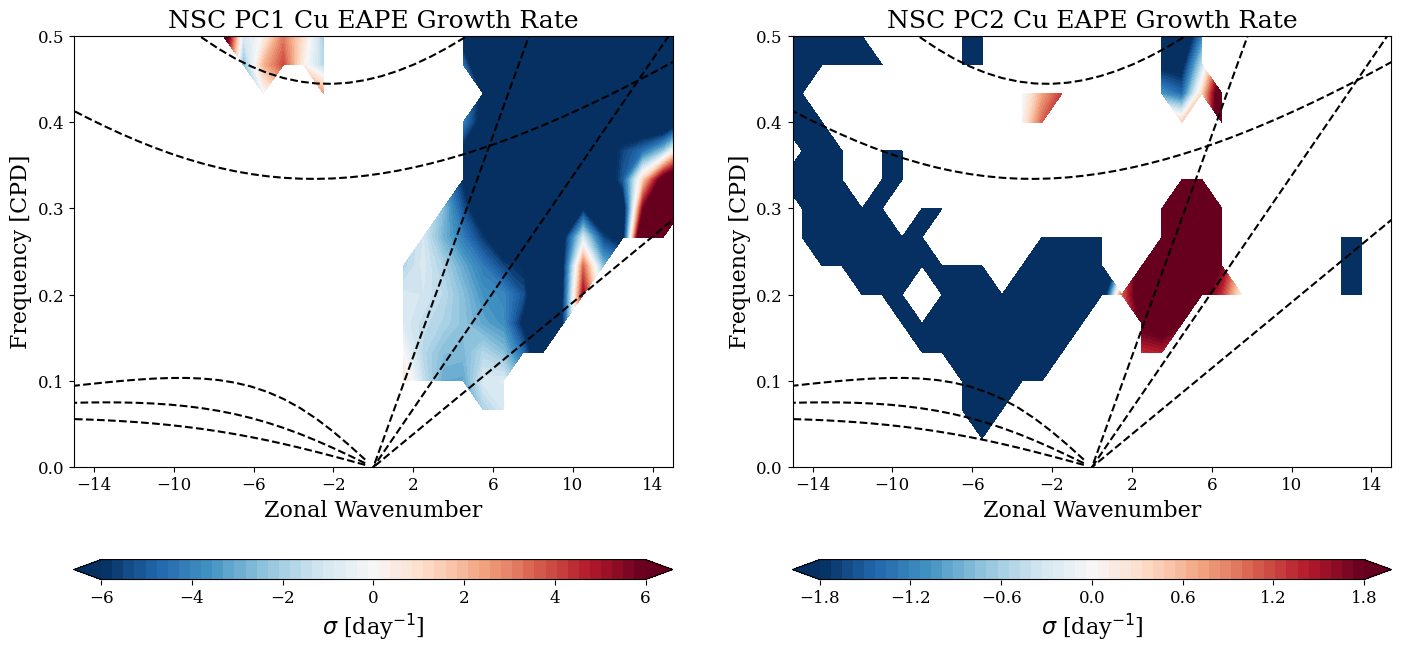

In [48]:

fig, ax = plt.subplots(1, 2, figsize=(17, 8))
c1 = ax[0].contourf(
    wnm, frm, 
    sigma_filted['pc1'],
    levels=np.linspace(-6, 6),
    cmap="RdBu_r",
    extend='both'
)
for i in range(3):
    ax[0].plot(wn_ana[3, i, e_cond], fr_ana[3, i, e_cond], 'k--')
    ax[0].plot(wn_ana[4, i, :], fr_ana[4, i, :], 'k--')
    ax[0].plot(wn_ana[5, i, :], fr_ana[5, i, :], 'k--')
ax[0].set_xticks(np.linspace(-14, 14, 8))
ax[0].set_yticks(np.linspace(0, 0.5, 6))
ax[0].set_xlim(-15, 15)
ax[0].set_ylim(0, 0.5)
ax[0].set_xlabel('Zonal Wavenumber')
ax[0].set_ylabel('Frequency [CPD]')
ax[0].set_title(f'{case} PC1 Cu EAPE Growth Rate')
cbar1 = plt.colorbar(
    c1,
    ax=ax[0],
    aspect=30,
    orientation='horizontal',
    label=r'$\sigma$ [day$^{-1}$]'
)
cbar1.set_ticks(np.linspace(-6, 6, 7))

c2 = ax[1].contourf(
    wnm, frm, 
    sigma_filted['pc2'],
    levels=np.linspace(-1.8, 1.8),
    cmap="RdBu_r",
    extend='both'
)
for i in range(3):
    ax[1].plot(wn_ana[3, i, e_cond], fr_ana[3, i, e_cond], 'k--')
    ax[1].plot(wn_ana[4, i, :], fr_ana[4, i, :], 'k--')
    ax[1].plot(wn_ana[5, i, :], fr_ana[5, i, :], 'k--')
ax[1].set_xticks(np.linspace(-14, 14, 8))
ax[1].set_yticks(np.linspace(0, 0.5, 6))
ax[1].set_xlim(-15, 15)
ax[1].set_ylim(0, 0.5)
ax[1].set_xlabel('Zonal Wavenumber')
ax[1].set_ylabel('Frequency [CPD]')
ax[1].set_title(f'{case} PC2 Cu EAPE Growth Rate')
cbar2 = plt.colorbar(
    c2,
    ax=ax[1],
    aspect=30,
    orientation='horizontal',
    label=r'$\sigma$ [day$^{-1}$]'
)
cbar2.set_ticks(np.linspace(-1.8, 1.8, 7))
plt.savefig(f'/home/b11209013/2024_Research/MPAS/GrowthRate/image/{case}/{case}_cu.svg')